# PyTorch CIFAR-10 categorisation project

1. Explore the data
1. Create a baseline to judge results against
1. Implement a neural network
1. Implement improvements
1. Evaluate different parameters

## 1. Explore the data

In [2]:
import torch
from torch import cuda
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import random

#set random seed for diff sources of randomness
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
rng = np.random.default_rng(seed=0)

In [3]:
data_folder = r"../data"

transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor()])
CIFAR_data = CIFAR10(data_folder, train=True, transform=transform, download=True)

train_dataloader = DataLoader(CIFAR_data,
                          batch_size=4,
                          shuffle=True)

CIFAR_test_data = CIFAR10(data_folder, train=False, transform=transform)

test_dataloader = DataLoader(CIFAR_test_data,
                              batch_size=4,
                              shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


### Visualise data

The next cell creates train_X, train_y type data which we use to visualise the data and run our benchmark categorisation. The training of Neural Nets uses PyTorch dataloaders and not the objects created in cell below.

To help with initial data exploration, convert the entire data training set to 
tensors.

In [4]:
# to do that explicitly below. Images in DataLoader objects have pixel values
# in (0,1). The CIFAR_data.data has int values in (0,255) so have to convert
# to floats to take mean etc further down
train_imgs = torch.tensor(CIFAR_data.data).float()/255
train_y = torch.tensor(CIFAR_data.targets)
test_imgs = torch.tensor(CIFAR_test_data.data).float()/255
test_y = torch.tensor(CIFAR_test_data.targets)

classes = CIFAR_data.classes

# We need a map to get from index to class name.
# So need to reverse .class_to_idx dict:
labels_map = {}
for key, val in CIFAR_data.class_to_idx.items():
    labels_map[val] = key

Plot random sample of the data:

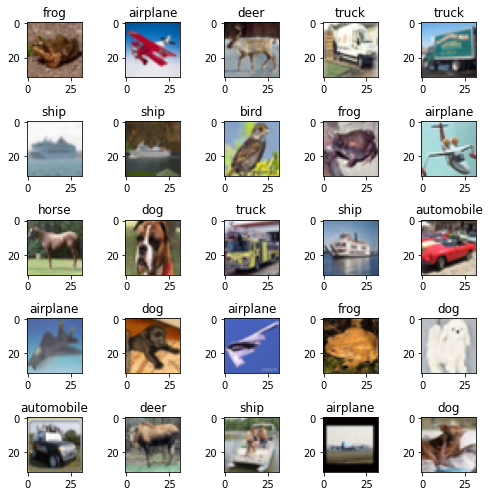

In [5]:
fig, axs = plt.subplots(5,5,figsize=(7,7))

for ax in axs.flatten():
    i = torch.randint(50000, (1,1)).item()
    ax.imshow(train_imgs[i])
    ax.set_title(labels_map[train_y[i].item()])
plt.tight_layout()

## Prepare data for benchmark categorisation

We create the training and validation data and labels.

The data is reshaped to a 4-dimensional tensor. dim 0 corresponds to list of images dim 1 is "depth" - so 3 layers for RGB; dim 2 and 3 are for the 32 pixels height and width of the images. 

We didvide pixel values by 255 so that PyTorch can work with floating point numbers in (0,1).

In [6]:
test_y.shape, test_imgs.shape, train_y.shape, train_imgs.shape

(torch.Size([10000]),
 torch.Size([10000, 32, 32, 3]),
 torch.Size([50000]),
 torch.Size([50000, 32, 32, 3]))

## Create a benchmark to judge neural net results against

Will an accuracy of above 10% imply that our neural net is doing better than chance and therefore doing a good job? Maybe.

To create a benchmark, we do a very simple prediction: we calculate the value of the "average" pixel for all the images in each category. Then for each image, we 

First create a benchmark to measure results of training neural net on.

We calculate the average RGB value for each pixel for each category. Then calculate the distance of an image form the average image for each category. Shortest distance is classified as that image. Can we do better than 10% accuracy??

In [7]:
avg_img = torch.zeros((10,32,32,3))
for i in np.arange(10):
    mask = train_y == i
    avg_img[i] = train_imgs[mask].mean(0)
    

Display our "average images". Kinda cool! The automobile and truck look like vehicles coming through the mist and the colours look different for different categories. There will be a lot of confusion between wild animals and cars/trucks for example, but the prediction based on distance from mean image should be quite good.

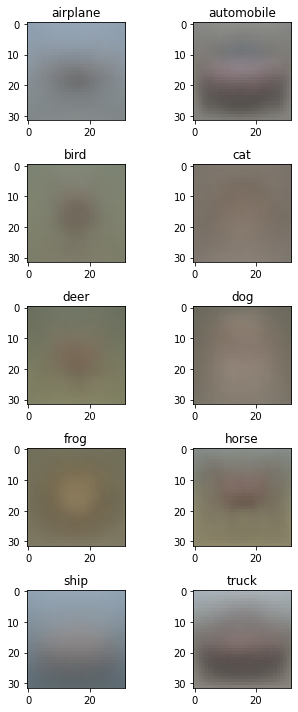

In [8]:
fig, axs = plt.subplots(5,2,figsize=(5,10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(avg_img[i])
    ax.set_title(labels_map[i])
plt.tight_layout()

Test our benchmark prediction. 28%!! Pretty good for just calculating an average. We now need our neural net to outperform 28% accuracy to be any good.

In [9]:
def cifar_distance(a,b): return ((a-b)**2).abs().mean((-1,-2,-3))
def predictions(a): return torch.argmin(a, dim=1)

preds = predictions(cifar_distance(test_imgs[:,None], avg_img[None]))
accuracy = (preds == test_y).sum()/test_imgs.shape[0]
accuracy

tensor(0.2774)

Just for curiousity, let's plot the confusion matrix. Some parts are as we expect from out crude method: it gets confused between deer and frogs (green backgrounds?) and birds and planes (sky?). 

Finally, there were 1000 of each category in the 10,000 test data set. However, our simple rule predicted either airplane or frog 4,500 times. So a lot of images look like the average frog or airplane!

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([2016,  657,  378,  211,  432, 1065, 2485,  622,  885, 1249]))

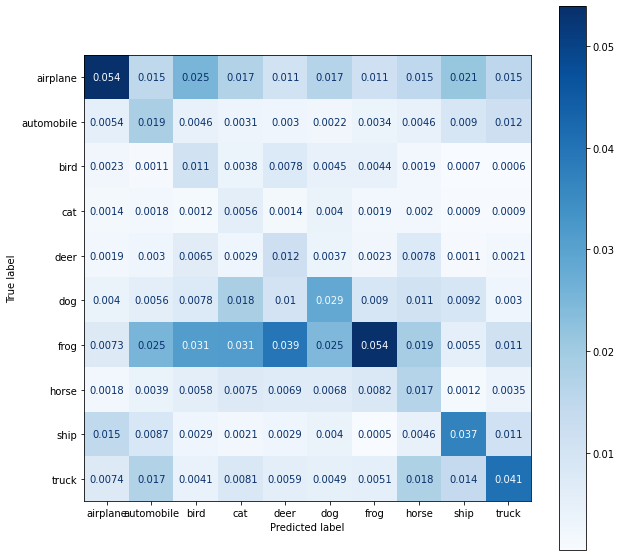

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display(torch.unique(preds, return_counts=True))

cm = confusion_matrix(preds, test_y,
                      normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes
                             )

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues')
ax.grid(False)

## 3. Implement a neural network

Create the initial neural network

In [11]:
device = torch.device('cuda:0' if cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Prepare the data. To check code runs, I will do a tiny amount of training data.

We also flatten the image data to vectors so that we can feed into a basic NN.

In [12]:
num_epochs = 10
batch_size = 64
learning_rate = 0.005

# I wasn't going to copy Cactus_classification, but defining 'criterion'
# gives good flexibility
criterion = nn.CrossEntropyLoss()

#### Prepare data

The code below is almost an exact copy of cell 2, above. We've recreated to give us the flexibility to have a smaller training and test set whilst running on local machines. We also have target tranform below which one-hot-encodes the labels.

In [13]:
transform = transforms.Compose([transforms.ToTensor(), #transforms.Resize(32),
                                # transforms.Lambda(lambda x: torch.flatten(x))
                               ])
target_transforms = transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float)
                                     .scatter_(0, torch.tensor(y), value=1))

# Prepare 1000 sample training set
CIFAR_data_small = CIFAR10(data_folder, train=True, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_data_small.data = CIFAR_data_small.data[:]
CIFAR_data_small.targets = CIFAR_data_small.targets[:]

# Prepare 1000 sample test set (weird balance, but easy to test)
CIFAR_test_small = CIFAR10(data_folder, train=False, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_test_small.data = CIFAR_test_small.data[:]
CIFAR_test_small.targets = CIFAR_test_small.targets[:]

train_small_dl = DataLoader(CIFAR_data_small,
                          batch_size=batch_size,
                          shuffle=True)

test_small_dl = DataLoader(CIFAR_test_small,
                          batch_size=batch_size,
                          shuffle=True)

In [14]:
CIFAR_data_small.data.shape, type(CIFAR_data_small.data), CIFAR_test_small.data.shape

((50000, 32, 32, 3), numpy.ndarray, (10000, 32, 32, 3))

Check that we have one-hot encoded the labels data. Looks like we have!

In [15]:
train_features, train_labels = next(iter(test_small_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].permute(1,2,0)
label = train_labels[0]
# plt.imshow(img)
# plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64, 10])
Label: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


In [16]:
# Define model

# models should subclass nn.Module. Docs here:
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # This flattens the 3 x 32 x 32 image matrices to vectors
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [17]:
# print("Model structure: ", model, "\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

## Training the model

In [18]:
def train_val(model, train_small_dl=train_small_dl, test_small_dl=test_small_dl,
              num_epochs=num_epochs, learning_rate=learning_rate, visible=True):
    
    criterion = nn.CrossEntropyLoss()
    # keeping-track-of-losses 
    train_losses = []
    valid_losses = []
    # set optimiser here - it uses model parameters as input
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

    for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
        train_loss = 0.0
        valid_loss = 0.0
    
    # training-the-model
        model.train()
        for data, target in train_small_dl:
        # move-tensors-to-GPU / CPU
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
        # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
        # calculate-the-batch-loss
            loss = criterion(output, target_i)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
        # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
        # update-training-loss
            train_loss += loss.item() * data.size(0)
        
    # validate-the-model
        model.eval()
        for data, target in test_small_dl:
        
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
            output = model(data)
        
            loss = criterion(output, target_i)
        
        # update-average-validation-loss 
            valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
        train_loss = train_loss/len(train_small_dl.sampler)
        valid_loss = valid_loss/len(test_small_dl.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
        if visible:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # plot-training/validation-statistics
    if visible:
        plt.plot(np.arange(1, num_epochs + 1), train_losses, label = "Training")
        plt.plot(np.arange(1, num_epochs + 1), valid_losses, label = "Validation")
        plt.title("Loss against Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

#simplified version of above without using test data
def train(model, train_small_dl=train_small_dl, num_epochs=num_epochs, learning_rate=learning_rate, visible=True):
    
    criterion = nn.CrossEntropyLoss()
    # keeping-track-of-losses 
    train_losses = []

    # set optimiser here - it uses model parameters as input
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

    for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
        train_loss = 0.0

    
    # training-the-model
        model.train()
        for data, target in train_small_dl:
        # move-tensors-to-GPU / CPU
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
        # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
        # calculate-the-batch-loss
            loss = criterion(output, target_i)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
        # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
        # update-training-loss
            train_loss += loss.item() * data.size(0)
        
    
    
    # calculate-average-losses
        train_loss = train_loss/len(train_small_dl.sampler)
      
        train_losses.append(train_loss)
        
    # print-training/validation-statistics 
        if visible:
            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # plot-training/validation-statistics
    if visible:
        plt.plot(np.arange(1, num_epochs + 1), train_losses, label = "Training")

        plt.title("Loss against Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


Epoch: 1 	Training Loss: 2.201343 	Validation Loss: 2.079126
Epoch: 2 	Training Loss: 2.006934 	Validation Loss: 1.948228
Epoch: 3 	Training Loss: 1.911688 	Validation Loss: 1.881571
Epoch: 4 	Training Loss: 1.857092 	Validation Loss: 1.846371
Epoch: 5 	Training Loss: 1.813651 	Validation Loss: 1.797574
Epoch: 6 	Training Loss: 1.775786 	Validation Loss: 1.774365
Epoch: 7 	Training Loss: 1.742757 	Validation Loss: 1.727165
Epoch: 8 	Training Loss: 1.714439 	Validation Loss: 1.712655
Epoch: 9 	Training Loss: 1.687783 	Validation Loss: 1.679439
Epoch: 10 	Training Loss: 1.662473 	Validation Loss: 1.672629


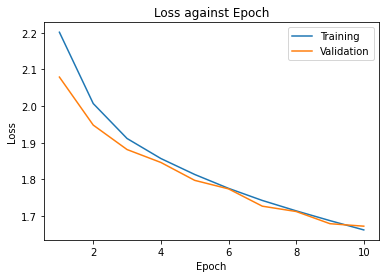

CPU times: user 2min 15s, sys: 1.42 s, total: 2min 17s
Wall time: 2min 18s


In [19]:
%%time
train_val(model)

## Test model on validation data

In [20]:
def test(model, test_small_dl=test_small_dl, visible=True):
    # test-the-model
    model.eval()  # it-disables-dropout
    with torch.no_grad():
        correct = 0
        total = 0
    # below calculates accuracy. Alex adapted from lab code and
    # it's not very pretty code. I transformed labels from one-
    # hot-encoded to integer labels and did the same for the 
    # softmax output in `predicted`
        for images, labels in test_small_dl:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data, dim=1)
            total += labels.size(0)
            labels = torch.argmax(labels, dim=1)
            correct += (predicted == labels).sum().item()
        
        accuracy = correct/total
        if visible:
            print('Test Accuracy of the model: {:.2f} %'.format(100 * accuracy))
    return accuracy

In [21]:
test(model)
# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 40.87 %


# Improvement

The accuracy doesn't look good enough. So let's explore any room for improvement, potentially:
- CNN
- Standard Normalization
- Regularization by dropout/L2
- More data
- tuning parameters: batch size, learning rate, no of epochs, optimizer

## CNN

CNN (convolutional neural network, also called ConvNet) is a popular technique for image classification in machine learning. Unlike traditional fully connected neural network, CNN somehow retains the spatial relationship among features (i.e. pixels) of images. In the below, we will keep the previous neural network structure in the end, but add CNN layers in the beginning. As the image is small, we will start with 3x3 kernel size, 2x2 max pooling, with suitable padding generating same output shape. 

Epoch: 1 	Training Loss: 1.907951 	Validation Loss: 2.574971
Epoch: 2 	Training Loss: 1.506444 	Validation Loss: 1.840826
Epoch: 3 	Training Loss: 1.314612 	Validation Loss: 1.267412
Epoch: 4 	Training Loss: 1.188487 	Validation Loss: 2.166045
Epoch: 5 	Training Loss: 1.081804 	Validation Loss: 1.613972
Epoch: 6 	Training Loss: 0.972932 	Validation Loss: 1.265713
Epoch: 7 	Training Loss: 0.860929 	Validation Loss: 1.403122
Epoch: 8 	Training Loss: 0.752451 	Validation Loss: 1.208489
Epoch: 9 	Training Loss: 0.640438 	Validation Loss: 1.273836
Epoch: 10 	Training Loss: 0.530170 	Validation Loss: 1.613954


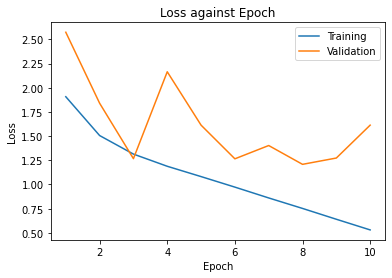

In [22]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            #https://cs231n.github.io/convolutional-networks/

#define model architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CNN().to(device)


#train the model
train_val(net, learning_rate=0.1)

#save
torch.save(net.state_dict(), './cifar_net.pth')

In [23]:
test(net)

Test Accuracy of the model: 56.70 %


0.567

Epoch: 1 	Training Loss: 2.008391 	Validation Loss: 2.181188
Epoch: 2 	Training Loss: 1.524067 	Validation Loss: 1.489759
Epoch: 3 	Training Loss: 1.262033 	Validation Loss: 1.339517
Epoch: 4 	Training Loss: 1.087531 	Validation Loss: 1.791057
Epoch: 5 	Training Loss: 0.944499 	Validation Loss: 1.320482
Epoch: 6 	Training Loss: 0.802765 	Validation Loss: 1.112516
Epoch: 7 	Training Loss: 0.667827 	Validation Loss: 1.013651
Epoch: 8 	Training Loss: 0.538940 	Validation Loss: 1.386806
Epoch: 9 	Training Loss: 0.413406 	Validation Loss: 1.102928
Epoch: 10 	Training Loss: 0.303680 	Validation Loss: 1.274134


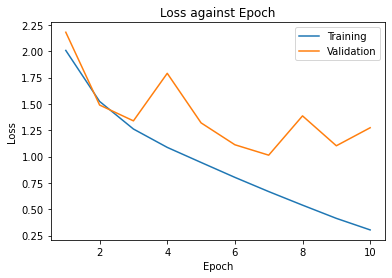

In [24]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            #https://cs231n.github.io/convolutional-networks/

#define model architecture
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.conv2 = nn.Conv2d(12, 48, 3, padding='same') ##2D convolution layer, 48 channels - kernels of 3x3, 
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net2 = CNN2().to(device)


#train the model
train_val(net2, learning_rate=0.1)

#save
torch.save(net2.state_dict(), './cifar_net2.pth')

In [25]:
test(net2)

Test Accuracy of the model: 64.77 %


0.6477

## Next step - tuning number of layers
For more systematic tuning, we first need to try different number of layers to determine the base structure we wish to tune.

Epoch: 1 	Training Loss: 1.804470 	Validation Loss: 1.606786
Epoch: 2 	Training Loss: 1.407619 	Validation Loss: 1.449022
Epoch: 3 	Training Loss: 1.215531 	Validation Loss: 1.496126
Epoch: 4 	Training Loss: 1.077573 	Validation Loss: 1.318788
Epoch: 5 	Training Loss: 0.960199 	Validation Loss: 1.408228
Epoch: 6 	Training Loss: 0.843640 	Validation Loss: 1.219744
Epoch: 7 	Training Loss: 0.731991 	Validation Loss: 1.227019
Epoch: 8 	Training Loss: 0.624891 	Validation Loss: 1.324868
Epoch: 9 	Training Loss: 0.515857 	Validation Loss: 1.966209
Epoch: 10 	Training Loss: 0.422658 	Validation Loss: 1.459849


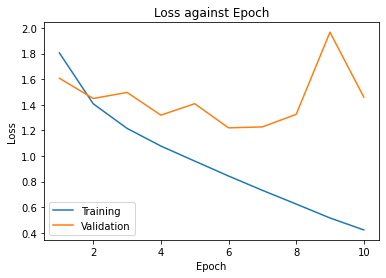

Test Accuracy of the model: 60.66 %


0.6066

In [26]:
#simplify by cutting one FC layer of CNN
class CNN1_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net1_2 = CNN1_2().to(device)


#train the model
train_val(net1_2, learning_rate=0.1)

#save
torch.save(net1_2.state_dict(), './cifar_net1_2.pth')

#testing vs test set
test(net1_2)

Epoch: 1 	Training Loss: 1.898420 	Validation Loss: 1.601641
Epoch: 2 	Training Loss: 1.441767 	Validation Loss: 1.435076
Epoch: 3 	Training Loss: 1.331572 	Validation Loss: 1.388767
Epoch: 4 	Training Loss: 1.264030 	Validation Loss: 1.753268
Epoch: 5 	Training Loss: 1.216920 	Validation Loss: 1.373592
Epoch: 6 	Training Loss: 1.180302 	Validation Loss: 1.574570
Epoch: 7 	Training Loss: 1.149898 	Validation Loss: 1.426383
Epoch: 8 	Training Loss: 1.126569 	Validation Loss: 1.247458
Epoch: 9 	Training Loss: 1.100381 	Validation Loss: 1.370971
Epoch: 10 	Training Loss: 1.079706 	Validation Loss: 1.314954


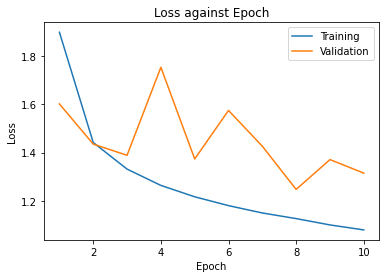

Test Accuracy of the model: 56.10 %


0.561

In [27]:
#simplify by cutting two FC layers of CNN
class CNN1_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return x

net1_3 = CNN1_3().to(device)


#train the model
train_val(net1_3, learning_rate=0.1)

#save
torch.save(net1_3.state_dict(), './cifar_net1_3.pth')

#testing vs test set
test(net1_3)

Epoch: 1 	Training Loss: 1.850582 	Validation Loss: 1.502147
Epoch: 2 	Training Loss: 1.378525 	Validation Loss: 1.312938
Epoch: 3 	Training Loss: 1.166385 	Validation Loss: 1.239847
Epoch: 4 	Training Loss: 0.996056 	Validation Loss: 1.398462
Epoch: 5 	Training Loss: 0.855490 	Validation Loss: 1.331823
Epoch: 6 	Training Loss: 0.722371 	Validation Loss: 1.067431
Epoch: 7 	Training Loss: 0.594157 	Validation Loss: 1.037368
Epoch: 8 	Training Loss: 0.463700 	Validation Loss: 1.054152
Epoch: 9 	Training Loss: 0.337832 	Validation Loss: 1.424104
Epoch: 10 	Training Loss: 0.236124 	Validation Loss: 1.270070


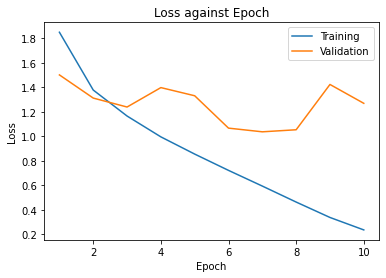

In [28]:
class CNN2_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.conv2 = nn.Conv2d(12, 48, 3, padding='same') ##2D convolution layer, 48 channels - kernels of 3x3, 
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net2_2 = CNN2_2().to(device)


#train the model
train_val(net2_2, learning_rate=0.1)


In [29]:
test(net2_2)

Test Accuracy of the model: 67.62 %


0.6762

# Dropout

As above charts show validation loss to diverge from trend of training loss, this suggest over-fitting. Now we try to improve by dropout, which is useful for regularization and avoid too much over-fitting.

Epoch: 1 	Training Loss: 2.017735 	Validation Loss: 2.144489
Epoch: 2 	Training Loss: 1.531805 	Validation Loss: 1.388383
Epoch: 3 	Training Loss: 1.324147 	Validation Loss: 1.214259
Epoch: 4 	Training Loss: 1.175731 	Validation Loss: 1.680385
Epoch: 5 	Training Loss: 1.054951 	Validation Loss: 1.114497
Epoch: 6 	Training Loss: 0.948142 	Validation Loss: 1.077872
Epoch: 7 	Training Loss: 0.854590 	Validation Loss: 1.109702
Epoch: 8 	Training Loss: 0.768238 	Validation Loss: 0.923630
Epoch: 9 	Training Loss: 0.688460 	Validation Loss: 1.013813
Epoch: 10 	Training Loss: 0.614049 	Validation Loss: 0.972410


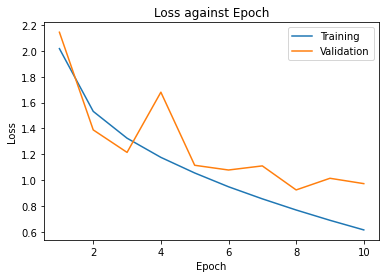

Test Accuracy of the model: 67.51 %


0.6751

In [30]:
class CNN2d(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.conv2 = nn.Conv2d(12, 48, 3, padding='same') ##2D convolution layer, 48 channels - kernels of 3x3, 
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

net2d = CNN2d().to(device)


#train the model
train_val(net2d, learning_rate=0.1)

#test
test(net2d)

Epoch: 1 	Training Loss: 2.060520 	Validation Loss: 1.878869
Epoch: 2 	Training Loss: 1.587176 	Validation Loss: 1.409764
Epoch: 3 	Training Loss: 1.336873 	Validation Loss: 1.260227
Epoch: 4 	Training Loss: 1.147123 	Validation Loss: 1.248912
Epoch: 5 	Training Loss: 1.004418 	Validation Loss: 1.290174
Epoch: 6 	Training Loss: 0.886293 	Validation Loss: 0.969417
Epoch: 7 	Training Loss: 0.795263 	Validation Loss: 0.894150
Epoch: 8 	Training Loss: 0.710242 	Validation Loss: 1.214190
Epoch: 9 	Training Loss: 0.629095 	Validation Loss: 0.874654
Epoch: 10 	Training Loss: 0.557193 	Validation Loss: 0.899995


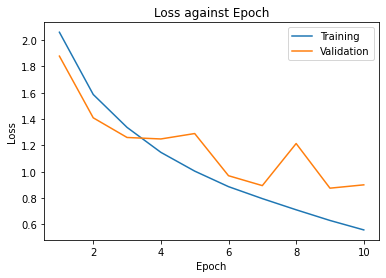

Test Accuracy of the model: 70.11 %


0.7011

In [31]:
class CNN3d(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.conv2 = nn.Conv2d(12, 48, 3, padding='same') ##2D convolution layer, 48 channels - kernels of 3x3, 
        self.conv3 = nn.Conv2d(48, 192, 3, padding='same') ##2D convolution layer
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

net3d = CNN3d().to(device)


#train the model
train_val(net3d, learning_rate=0.1)

#test
test(net3d)

Epoch: 1 	Training Loss: 2.141599 	Validation Loss: 1.910410
Epoch: 2 	Training Loss: 1.697940 	Validation Loss: 1.686175
Epoch: 3 	Training Loss: 1.440064 	Validation Loss: 1.316314
Epoch: 4 	Training Loss: 1.289102 	Validation Loss: 1.414742
Epoch: 5 	Training Loss: 1.171181 	Validation Loss: 1.109385
Epoch: 6 	Training Loss: 1.069975 	Validation Loss: 1.112752
Epoch: 7 	Training Loss: 0.992870 	Validation Loss: 0.950265
Epoch: 8 	Training Loss: 0.915301 	Validation Loss: 1.069304
Epoch: 9 	Training Loss: 0.864360 	Validation Loss: 0.970326
Epoch: 10 	Training Loss: 0.809484 	Validation Loss: 0.855976


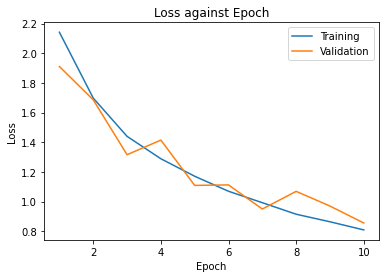

Test Accuracy of the model: 70.75 %


0.7075

In [32]:
class CNN3d(nn.Module):
    def __init__(self, p=0.4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.conv2 = nn.Conv2d(12, 48, 3, padding='same') ##2D convolution layer, 48 channels - kernels of 3x3, 
        self.conv3 = nn.Conv2d(48, 192, 3, padding='same') ##2D convolution layer
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

net3d = CNN3d().to(device)


#train the model
train_val(net3d, learning_rate=0.1)

#test
test(net3d)

# Test and Evaluate Parameters

Since the data is balanced among different classes, we can simply use accuracy to evaluate models and ignore confusion matrix. So from above test accuracy of different models, we will choose this base model" 3 convolution layers (each with kernels of size 3x3, max pool of (2, 2), padding =1, stride =1, with Relu activation) followed by 3 fully connected layers (all Relu except output layer using softmax), with dropout used.

In [35]:
#create a general class of CNN with 3 conv layers, 3 FC layers
class CNN_variant(nn.Module):
    def __init__(self, k=12, n=512, p=0.4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, k, 3, padding='same') #2D convolution layer, k channels - kernels of 3x3, 
        self.conv2 = nn.Conv2d(k, 4*k, 3, padding='same') ##2D convolution layer, 4k channels - kernels of 3x3, 
        self.conv3 = nn.Conv2d(4*k, 16*k, 3, padding='same') ##2D convolution layer,
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(256*k, n)
        self.fc2 = nn.Linear(n, n)
        self.fc3 = nn.Linear(n, 10)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Epoch: 1 	Training Loss: 2.153735 	Validation Loss: 1.905715
Epoch: 2 	Training Loss: 1.799078 	Validation Loss: 1.627746
Epoch: 3 	Training Loss: 1.570816 	Validation Loss: 1.488081
Epoch: 4 	Training Loss: 1.436484 	Validation Loss: 1.320126
Epoch: 5 	Training Loss: 1.328022 	Validation Loss: 1.204166
Epoch: 6 	Training Loss: 1.247351 	Validation Loss: 1.158339
Epoch: 7 	Training Loss: 1.181787 	Validation Loss: 1.092558
Epoch: 8 	Training Loss: 1.123650 	Validation Loss: 1.156698
Epoch: 9 	Training Loss: 1.077708 	Validation Loss: 1.232561
Epoch: 10 	Training Loss: 1.034668 	Validation Loss: 1.114652


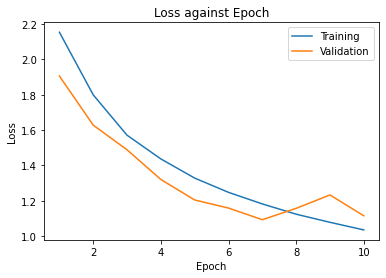

Test Accuracy of the model: 60.60 %
test accuracy for k=6; n=256: 60.6%
Epoch: 1 	Training Loss: 2.174651 	Validation Loss: 1.944707
Epoch: 2 	Training Loss: 1.800745 	Validation Loss: 1.670986
Epoch: 3 	Training Loss: 1.526036 	Validation Loss: 1.753889
Epoch: 4 	Training Loss: 1.383174 	Validation Loss: 1.319110
Epoch: 5 	Training Loss: 1.277912 	Validation Loss: 1.210560
Epoch: 6 	Training Loss: 1.195172 	Validation Loss: 1.690788
Epoch: 7 	Training Loss: 1.129837 	Validation Loss: 1.042462
Epoch: 8 	Training Loss: 1.075633 	Validation Loss: 1.018770
Epoch: 9 	Training Loss: 1.025924 	Validation Loss: 1.093142
Epoch: 10 	Training Loss: 0.981430 	Validation Loss: 0.996738


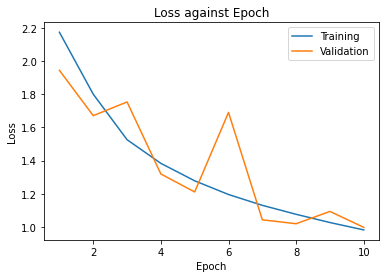

Test Accuracy of the model: 64.85 %
test accuracy for k=6; n=512: 64.85%
Epoch: 1 	Training Loss: 2.174409 	Validation Loss: 1.950073
Epoch: 2 	Training Loss: 1.838430 	Validation Loss: 1.992859
Epoch: 3 	Training Loss: 1.552321 	Validation Loss: 1.779438
Epoch: 4 	Training Loss: 1.385415 	Validation Loss: 1.313777
Epoch: 5 	Training Loss: 1.255678 	Validation Loss: 1.251164
Epoch: 6 	Training Loss: 1.158699 	Validation Loss: 1.748480
Epoch: 7 	Training Loss: 1.080813 	Validation Loss: 1.118077
Epoch: 8 	Training Loss: 1.017930 	Validation Loss: 1.008103
Epoch: 9 	Training Loss: 0.960712 	Validation Loss: 1.005293
Epoch: 10 	Training Loss: 0.919535 	Validation Loss: 1.014488


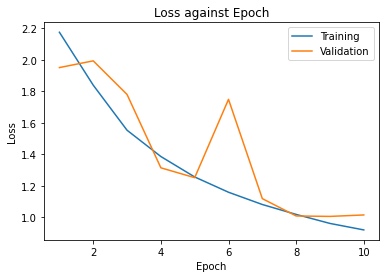

Test Accuracy of the model: 64.34 %
test accuracy for k=6; n=1024: 64.34%
Epoch: 1 	Training Loss: 2.182178 	Validation Loss: 1.928798
Epoch: 2 	Training Loss: 1.749496 	Validation Loss: 1.724020
Epoch: 3 	Training Loss: 1.482324 	Validation Loss: 1.427286
Epoch: 4 	Training Loss: 1.337320 	Validation Loss: 1.327219
Epoch: 5 	Training Loss: 1.221441 	Validation Loss: 1.224429
Epoch: 6 	Training Loss: 1.116016 	Validation Loss: 1.141299
Epoch: 7 	Training Loss: 1.028046 	Validation Loss: 0.948728
Epoch: 8 	Training Loss: 0.957251 	Validation Loss: 0.980792
Epoch: 9 	Training Loss: 0.893793 	Validation Loss: 0.986991
Epoch: 10 	Training Loss: 0.850995 	Validation Loss: 0.980134


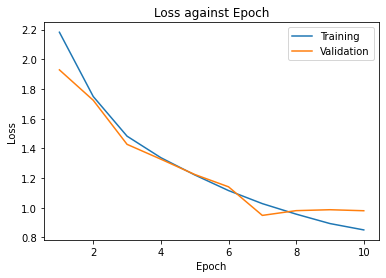

Test Accuracy of the model: 66.08 %
test accuracy for k=12; n=256: 66.08000000000001%
Epoch: 1 	Training Loss: 2.126613 	Validation Loss: 1.892568
Epoch: 2 	Training Loss: 1.742324 	Validation Loss: 1.569958
Epoch: 3 	Training Loss: 1.468296 	Validation Loss: 1.611902
Epoch: 4 	Training Loss: 1.309526 	Validation Loss: 1.263211
Epoch: 5 	Training Loss: 1.178978 	Validation Loss: 1.196401
Epoch: 6 	Training Loss: 1.069398 	Validation Loss: 1.060465
Epoch: 7 	Training Loss: 0.982858 	Validation Loss: 0.985350
Epoch: 8 	Training Loss: 0.911192 	Validation Loss: 0.877999
Epoch: 9 	Training Loss: 0.846532 	Validation Loss: 0.886294
Epoch: 10 	Training Loss: 0.791928 	Validation Loss: 1.437389


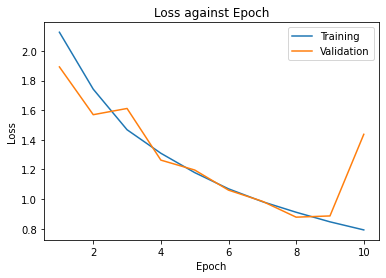

Test Accuracy of the model: 55.88 %
test accuracy for k=12; n=512: 55.879999999999995%
Epoch: 1 	Training Loss: 2.136187 	Validation Loss: 1.904917
Epoch: 2 	Training Loss: 1.676804 	Validation Loss: 1.811695
Epoch: 3 	Training Loss: 1.422062 	Validation Loss: 1.416911
Epoch: 4 	Training Loss: 1.266626 	Validation Loss: 1.156953
Epoch: 5 	Training Loss: 1.146633 	Validation Loss: 1.192097
Epoch: 6 	Training Loss: 1.046369 	Validation Loss: 1.283230
Epoch: 7 	Training Loss: 0.961970 	Validation Loss: 1.034760
Epoch: 8 	Training Loss: 0.889136 	Validation Loss: 0.898589
Epoch: 9 	Training Loss: 0.824928 	Validation Loss: 0.929948
Epoch: 10 	Training Loss: 0.773875 	Validation Loss: 0.838223


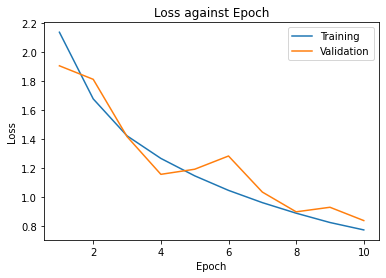

Test Accuracy of the model: 71.22 %
test accuracy for k=12; n=1024: 71.22%
Epoch: 1 	Training Loss: 2.088386 	Validation Loss: 1.921129
Epoch: 2 	Training Loss: 1.655347 	Validation Loss: 1.561253
Epoch: 3 	Training Loss: 1.393501 	Validation Loss: 1.433921
Epoch: 4 	Training Loss: 1.214316 	Validation Loss: 1.379853
Epoch: 5 	Training Loss: 1.080148 	Validation Loss: 1.069462
Epoch: 6 	Training Loss: 0.972223 	Validation Loss: 1.084715
Epoch: 7 	Training Loss: 0.875713 	Validation Loss: 0.895364
Epoch: 8 	Training Loss: 0.812886 	Validation Loss: 0.788378
Epoch: 9 	Training Loss: 0.748306 	Validation Loss: 0.874082
Epoch: 10 	Training Loss: 0.693573 	Validation Loss: 0.882530


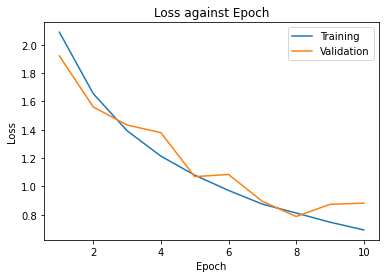

Test Accuracy of the model: 70.31 %
test accuracy for k=24; n=256: 70.30999999999999%
Epoch: 1 	Training Loss: 2.118722 	Validation Loss: 2.087667
Epoch: 2 	Training Loss: 1.639307 	Validation Loss: 1.773071
Epoch: 3 	Training Loss: 1.354594 	Validation Loss: 1.677775
Epoch: 4 	Training Loss: 1.150505 	Validation Loss: 1.341826
Epoch: 5 	Training Loss: 1.009979 	Validation Loss: 0.931833
Epoch: 6 	Training Loss: 0.899071 	Validation Loss: 1.074000
Epoch: 7 	Training Loss: 0.808474 	Validation Loss: 0.849664
Epoch: 8 	Training Loss: 0.729108 	Validation Loss: 0.753031
Epoch: 9 	Training Loss: 0.661033 	Validation Loss: 0.993031
Epoch: 10 	Training Loss: 0.600009 	Validation Loss: 0.805272


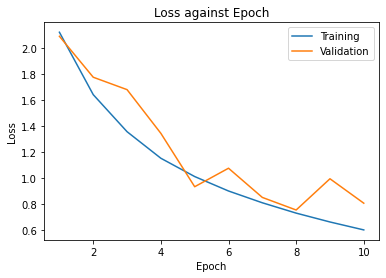

Test Accuracy of the model: 72.51 %
test accuracy for k=24; n=512: 72.50999999999999%
Epoch: 1 	Training Loss: 2.126093 	Validation Loss: 1.972178
Epoch: 2 	Training Loss: 1.624795 	Validation Loss: 1.490496
Epoch: 3 	Training Loss: 1.348877 	Validation Loss: 1.627768
Epoch: 4 	Training Loss: 1.151339 	Validation Loss: 1.685918
Epoch: 5 	Training Loss: 1.002048 	Validation Loss: 1.003743
Epoch: 6 	Training Loss: 0.885984 	Validation Loss: 0.905534
Epoch: 7 	Training Loss: 0.784644 	Validation Loss: 0.948063
Epoch: 8 	Training Loss: 0.701521 	Validation Loss: 1.059273
Epoch: 9 	Training Loss: 0.629836 	Validation Loss: 0.867104
Epoch: 10 	Training Loss: 0.564080 	Validation Loss: 0.826500


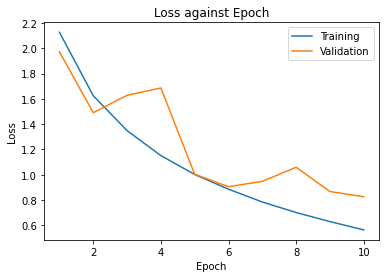

Test Accuracy of the model: 72.49 %
test accuracy for k=24; n=1024: 72.49%


In [36]:
#Create, train and test variants of CNN
CNNs={}
accuracy={}
for k in [6,12,24]:
    CNNs[k]={}
    accuracy[k]={}
    for n in [256, 512, 1024]:
          CNNs[k][n]=CNN_variant(k, n).to(device)
          train_val(CNNs[k][n], learning_rate=0.1)
          accuracy[k][n]=test(CNNs[k][n])
          print('test accuracy for k='+str(k)+'; n='+str(n)+': '+str(100*accuracy[k][n])+'%')

In [44]:
print('Test accuracy of CNN variants')
print('Accuracy  n=256  n=512   n=1024',end='')
for k in [6,12,24]:
  print('')
  print('k='+str(k)+'      ', end='')
  for n in [256,512,1024]:
    print("{:.2f}".format(accuracy[k][n]*100)+'% ', end='')

Test accuracy of CNN variants
Accuracy  n=256  n=512   n=1024
k=6      60.60% 64.85% 64.34% 
k=12      66.08% 55.88% 71.22% 
k=24      70.31% 72.51% 72.49% 

The model k=24, n=512 has highest test accuracy: 72.51 %

# Tuning Learning Rate and dropout
Dropout is first proposed by Hinton G., in which he suggested learning rate be adjusted appropriately with the use of dropout. Hence, we now tune them together.

Epoch: 1 	Training Loss: 2.092973 	Validation Loss: 1.807392
Epoch: 2 	Training Loss: 1.586035 	Validation Loss: 1.578439
Epoch: 3 	Training Loss: 1.316893 	Validation Loss: 1.328205
Epoch: 4 	Training Loss: 1.133815 	Validation Loss: 1.102815
Epoch: 5 	Training Loss: 1.000312 	Validation Loss: 1.065818
Epoch: 6 	Training Loss: 0.898621 	Validation Loss: 0.888005
Epoch: 7 	Training Loss: 0.824739 	Validation Loss: 1.008037
Epoch: 8 	Training Loss: 0.751666 	Validation Loss: 1.284545
Epoch: 9 	Training Loss: 0.698324 	Validation Loss: 1.107283
Epoch: 10 	Training Loss: 0.650971 	Validation Loss: 0.895528


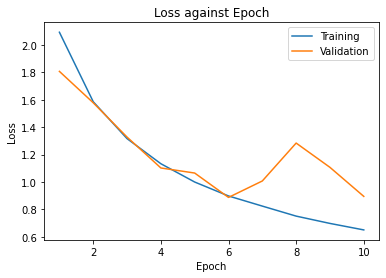

Test Accuracy of the model: 69.32 %
test accuracy for lr=0.2; p=0.4: 69.32000000000001%
Epoch: 1 	Training Loss: 2.077830 	Validation Loss: 1.753889
Epoch: 2 	Training Loss: 1.642830 	Validation Loss: 1.472761
Epoch: 3 	Training Loss: 1.427942 	Validation Loss: 1.383450
Epoch: 4 	Training Loss: 1.281034 	Validation Loss: 1.399227
Epoch: 5 	Training Loss: 1.177632 	Validation Loss: 1.266417
Epoch: 6 	Training Loss: 1.104950 	Validation Loss: 1.161356
Epoch: 7 	Training Loss: 1.045617 	Validation Loss: 1.071488
Epoch: 8 	Training Loss: 0.998757 	Validation Loss: 1.143695
Epoch: 9 	Training Loss: 0.964438 	Validation Loss: 1.057601
Epoch: 10 	Training Loss: 0.937696 	Validation Loss: 0.960228


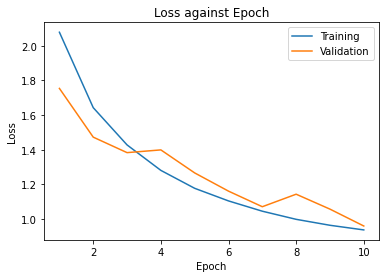

Test Accuracy of the model: 66.79 %
test accuracy for lr=0.2; p=0.6: 66.79%
Epoch: 1 	Training Loss: 2.295102 	Validation Loss: 2.302278
Epoch: 2 	Training Loss: 2.246296 	Validation Loss: 1.970057
Epoch: 3 	Training Loss: 2.004009 	Validation Loss: 1.910889
Epoch: 4 	Training Loss: 1.898987 	Validation Loss: 1.878794
Epoch: 5 	Training Loss: 1.853338 	Validation Loss: 1.974313
Epoch: 6 	Training Loss: 1.818156 	Validation Loss: 1.802762
Epoch: 7 	Training Loss: 1.791569 	Validation Loss: 1.795483
Epoch: 8 	Training Loss: 1.766558 	Validation Loss: 2.037273
Epoch: 9 	Training Loss: 1.756881 	Validation Loss: 1.802912
Epoch: 10 	Training Loss: 1.746391 	Validation Loss: 1.773263


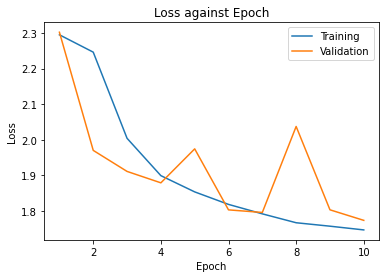

Test Accuracy of the model: 34.62 %
test accuracy for lr=0.2; p=0.8: 34.62%
Epoch: 1 	Training Loss: 2.092338 	Validation Loss: 1.815924
Epoch: 2 	Training Loss: 1.607182 	Validation Loss: 1.496491
Epoch: 3 	Training Loss: 1.360723 	Validation Loss: 1.336607
Epoch: 4 	Training Loss: 1.172394 	Validation Loss: 1.069021
Epoch: 5 	Training Loss: 1.017708 	Validation Loss: 1.070897
Epoch: 6 	Training Loss: 0.906583 	Validation Loss: 0.953201
Epoch: 7 	Training Loss: 0.814143 	Validation Loss: 1.069053
Epoch: 8 	Training Loss: 0.733149 	Validation Loss: 0.998319
Epoch: 9 	Training Loss: 0.663238 	Validation Loss: 0.815583
Epoch: 10 	Training Loss: 0.612026 	Validation Loss: 1.155948


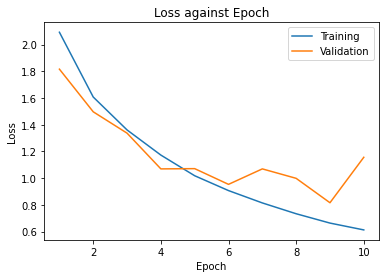

Test Accuracy of the model: 62.54 %
test accuracy for lr=0.1; p=0.4: 62.53999999999999%
Epoch: 1 	Training Loss: 2.137777 	Validation Loss: 1.855602
Epoch: 2 	Training Loss: 1.711388 	Validation Loss: 1.539906
Epoch: 3 	Training Loss: 1.491234 	Validation Loss: 1.352679
Epoch: 4 	Training Loss: 1.325799 	Validation Loss: 1.196838
Epoch: 5 	Training Loss: 1.186636 	Validation Loss: 1.219605
Epoch: 6 	Training Loss: 1.085571 	Validation Loss: 1.025686
Epoch: 7 	Training Loss: 1.002364 	Validation Loss: 1.110964
Epoch: 8 	Training Loss: 0.936164 	Validation Loss: 0.979396
Epoch: 9 	Training Loss: 0.879976 	Validation Loss: 0.846276
Epoch: 10 	Training Loss: 0.831700 	Validation Loss: 0.889510


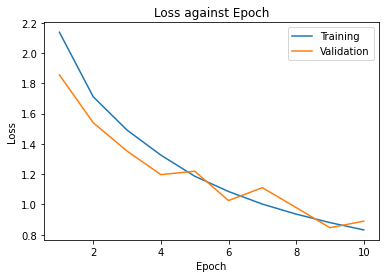

Test Accuracy of the model: 69.21 %
test accuracy for lr=0.1; p=0.6: 69.21000000000001%
Epoch: 1 	Training Loss: 2.226630 	Validation Loss: 2.078877
Epoch: 2 	Training Loss: 1.940099 	Validation Loss: 1.779333
Epoch: 3 	Training Loss: 1.788597 	Validation Loss: 1.625391
Epoch: 4 	Training Loss: 1.672904 	Validation Loss: 1.667563
Epoch: 5 	Training Loss: 1.583335 	Validation Loss: 1.494271
Epoch: 6 	Training Loss: 1.513628 	Validation Loss: 1.427395
Epoch: 7 	Training Loss: 1.453005 	Validation Loss: 1.427973
Epoch: 8 	Training Loss: 1.404954 	Validation Loss: 1.224188
Epoch: 9 	Training Loss: 1.358485 	Validation Loss: 1.337358
Epoch: 10 	Training Loss: 1.322189 	Validation Loss: 1.249795


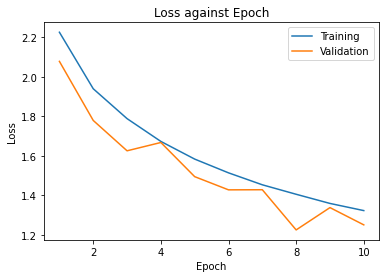

Test Accuracy of the model: 56.22 %
test accuracy for lr=0.1; p=0.8: 56.220000000000006%
Epoch: 1 	Training Loss: 2.206803 	Validation Loss: 2.095880
Epoch: 2 	Training Loss: 1.817150 	Validation Loss: 1.745663
Epoch: 3 	Training Loss: 1.558106 	Validation Loss: 1.432713
Epoch: 4 	Training Loss: 1.395498 	Validation Loss: 1.305996
Epoch: 5 	Training Loss: 1.258361 	Validation Loss: 1.304845
Epoch: 6 	Training Loss: 1.133871 	Validation Loss: 1.173427
Epoch: 7 	Training Loss: 1.027558 	Validation Loss: 1.318206
Epoch: 8 	Training Loss: 0.929211 	Validation Loss: 1.146239
Epoch: 9 	Training Loss: 0.855804 	Validation Loss: 0.898689
Epoch: 10 	Training Loss: 0.789889 	Validation Loss: 0.990345


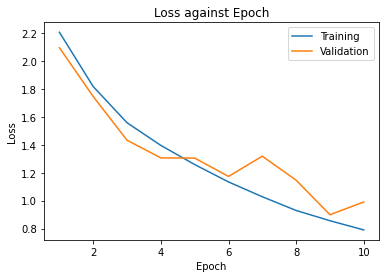

Test Accuracy of the model: 66.46 %
test accuracy for lr=0.05; p=0.4: 66.46%
Epoch: 1 	Training Loss: 2.239000 	Validation Loss: 2.091859
Epoch: 2 	Training Loss: 1.916201 	Validation Loss: 1.723354
Epoch: 3 	Training Loss: 1.670664 	Validation Loss: 1.493208
Epoch: 4 	Training Loss: 1.518821 	Validation Loss: 1.489255
Epoch: 5 	Training Loss: 1.395065 	Validation Loss: 1.334828
Epoch: 6 	Training Loss: 1.287518 	Validation Loss: 1.387781
Epoch: 7 	Training Loss: 1.191578 	Validation Loss: 1.541192
Epoch: 8 	Training Loss: 1.104341 	Validation Loss: 1.082067
Epoch: 9 	Training Loss: 1.025927 	Validation Loss: 0.932533
Epoch: 10 	Training Loss: 0.967496 	Validation Loss: 0.963976


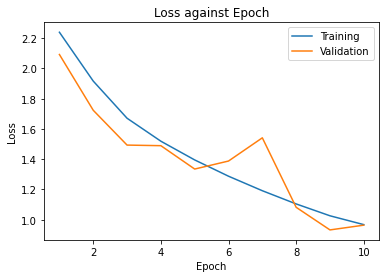

Test Accuracy of the model: 65.74 %
test accuracy for lr=0.05; p=0.6: 65.74%
Epoch: 1 	Training Loss: 2.281098 	Validation Loss: 2.173726
Epoch: 2 	Training Loss: 2.093788 	Validation Loss: 1.908645
Epoch: 3 	Training Loss: 1.903330 	Validation Loss: 1.731560
Epoch: 4 	Training Loss: 1.782342 	Validation Loss: 1.689520
Epoch: 5 	Training Loss: 1.687701 	Validation Loss: 1.600063
Epoch: 6 	Training Loss: 1.597117 	Validation Loss: 1.508412
Epoch: 7 	Training Loss: 1.528914 	Validation Loss: 1.643243
Epoch: 8 	Training Loss: 1.460641 	Validation Loss: 1.362931
Epoch: 9 	Training Loss: 1.397967 	Validation Loss: 1.199174
Epoch: 10 	Training Loss: 1.347089 	Validation Loss: 1.236099


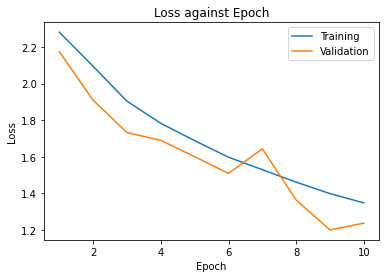

Test Accuracy of the model: 55.22 %
test accuracy for lr=0.05; p=0.8: 55.22%


In [40]:
#Create, train and test variants of CNN
k=24
n=512
CNN_lrp={}
accuracy_lrp={}
for lr in [0.2,0.1,0.05]:
    CNN_lrp[lr]={}
    accuracy_lrp[lr]={}
    for p in [0.4, 0.6, 0.8]:
          seed =0
          torch.manual_seed(seed)
          random.seed(seed)
          np.random.seed(seed)
          rng = np.random.default_rng(seed=seed)
          CNN_lrp[lr][p]=CNN_variant(k, n, p).to(device)
          train_val(CNN_lrp[lr][p], learning_rate=lr)
          accuracy_lrp[lr][p]=test(CNN_lrp[lr][p])
          print('test accuracy for lr='+str(lr)+'; p='+str(p)+': '+str(100*accuracy_lrp[lr][p])+'%')

In [48]:
print('Test accuracy of CNN variants')
print('Accuracy  p=0.4  p=0.6  p=0.8',end='')
for lr in [0.2,0.1,0.05]:
  print('')
  print('lr='+str(lr)+'    ', end='')
  for p in [0.4,0.6,0.8]:
    print("{:.2f}".format(accuracy_lrp[lr][p]*100)+'% ', end='')

Test accuracy of CNN variants
Accuracy  p=0.4  p=0.6  p=0.8
lr=0.2    69.32% 66.79% 34.62% 
lr=0.1    62.54% 69.21% 56.22% 
lr=0.05    66.46% 65.74% 55.22% 

The model with learning rate 0.2 and dropout rate 0.4 has highest test accuracy 69.32%.

Before we conclude, let's test the robustness against randomness, and use a training function that enables us to see validation loss as well.


Epoch: 1 	Training Loss: 2.044602 	Validation Loss: 2.062616
Epoch: 2 	Training Loss: 1.530030 	Validation Loss: 1.672103
Epoch: 3 	Training Loss: 1.269372 	Validation Loss: 1.348778
Epoch: 4 	Training Loss: 1.093539 	Validation Loss: 1.183261
Epoch: 5 	Training Loss: 0.967517 	Validation Loss: 0.955170
Epoch: 6 	Training Loss: 0.865232 	Validation Loss: 1.021862
Epoch: 7 	Training Loss: 0.792676 	Validation Loss: 0.953436
Epoch: 8 	Training Loss: 0.720722 	Validation Loss: 0.847929
Epoch: 9 	Training Loss: 0.666370 	Validation Loss: 0.862082
Epoch: 10 	Training Loss: 0.612857 	Validation Loss: 0.750137


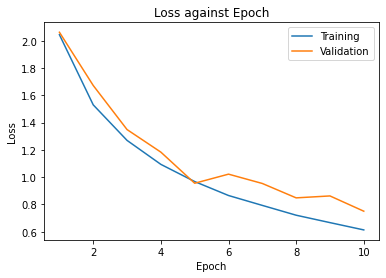

Test Accuracy of the model: 74.03 %


0.7403

In [50]:
lr = 0.2
p = 0.4
seed=1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)
CNN_lrp[lr][p]=CNN_variant(24, 512, p).to(device)
train_val(CNN_lrp[lr][p], learning_rate=lr)
test(CNN_lrp[lr][p])

Epoch: 1 	Training Loss: 2.072480 	Validation Loss: 1.665226
Epoch: 2 	Training Loss: 1.512355 	Validation Loss: 1.288806
Epoch: 3 	Training Loss: 1.243712 	Validation Loss: 1.159599
Epoch: 4 	Training Loss: 1.059458 	Validation Loss: 1.058779
Epoch: 5 	Training Loss: 0.932317 	Validation Loss: 1.222400
Epoch: 6 	Training Loss: 0.833418 	Validation Loss: 0.826613
Epoch: 7 	Training Loss: 0.756689 	Validation Loss: 0.918387
Epoch: 8 	Training Loss: 0.691355 	Validation Loss: 0.993305
Epoch: 9 	Training Loss: 0.629609 	Validation Loss: 0.860286
Epoch: 10 	Training Loss: 0.581807 	Validation Loss: 0.727328


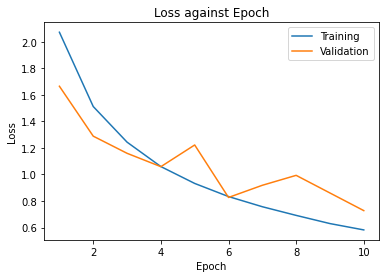

Test Accuracy of the model: 75.37 %


0.7537

In [51]:
seed=2
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)
CNN_lrp[lr][p]=CNN_variant(24, 512, p).to(device)
train_val(CNN_lrp[lr][p], learning_rate=lr)
test(CNN_lrp[lr][p])

# Conclusion
So after above tuning, the optimal model is:

(k=24, n=512), i.e.
3 convolutional layers of 24/96/384 channels (each with kernels size 3, stride 1, padding 1, with Max Pool(2,2) then RELU), followed by 2 hidden fully connected layers (each 512 nodes, RELU) and 1 output layer (10 classes) using Pytorch SGD optimizer with batch size 100, 10 epochs and cross-entropy loss function, at learning rate 0.2 and dropout rate 0.4.

Its average test accuracy among 3 trianings is 72.9%.

Disclaimer: we cannot guarantee it has similar accuracy in every random state, though we have tested multiple random states for initialization of weights and training. Please note that according to PyTorch, completely reproducible results are not guaranteed across PyTorch releases, individual commits, different platforms, or between CPU and GPU executions. (https://pytorch.org/docs/stable/notes/randomness.html).

Let's save the final model.

In [52]:
torch.save(CNN_lrp[lr][p].state_dict(), './cifar_CNN_final.pth')

### Reference
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://cs231n.github.io/convolutional-networks/

https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module